In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from torchvision import models

from datasets import ImagenetDataset
from fooling_model import VGG16FoolingModel, VGG19FoolingModel, ResNet50FoolingModel
from utils import calculate_fooling_rate, construct_perturbation, process_image

In [2]:
np.random.seed(2)
torch.manual_seed(2)
torch.backends.cudnn.deterministic = True

In [3]:
MAX_PERTURB_NORM = 10
p = np.inf
q = 10.0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

imgs_dir = 'imgs'
imgs_paths = [os.path.join(imgs_dir, img_name) for img_name in os.listdir(imgs_dir)]

In [ ]:
fooling_model = VGG19FoolingModel(models.vgg19(pretrained=True)).to(device)
fooling_model.eval();

In [ ]:
bs_pool = list(range(5, 101, 5))
fooling_rates = []
perturbations = []

for bs in bs_pool:
    train_paths = np.random.choice(imgs_paths, size=bs, replace=False)
    val_paths = list(set(imgs_paths) - set(train_paths))
    train_dataset = ImagenetDataset(train_paths, device)
    val_dataset = ImagenetDataset(val_paths, device)
    perturbation = construct_perturbation(
        model=fooling_model,
        layer_id=fooling_model.LAYERS_IDS['block2_pool'],
        train_batch=train_dataset[:],
        perturb_norm=MAX_PERTURB_NORM,
        p=p,
        q=q
    )
    fooling_rate = calculate_fooling_rate(
        model=fooling_model,
        perturbation=perturbation,
        val_data=val_dataset
    )
    fooling_rates.append(fooling_rate)
    perturbations.append(petrurbation.cpu())

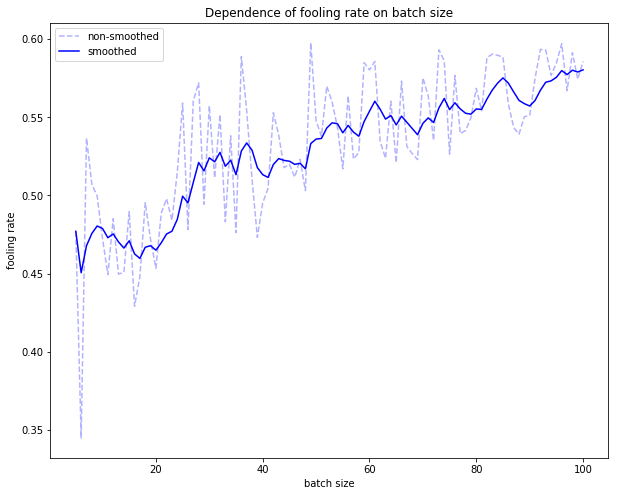

In [26]:
plt.figure(figsize=(10, 8))
plt.title('Dependence of fooling rate on batch size')
plt.xlabel('batch size')
plt.ylabel('fooling rate')
plt.plot(bs_pool, fooling_rates, 'b--', alpha=0.3, label='non-smoothed')
smoothed = list(itertools.accumulate(fooling_rates,lambda x,y : x * 0.8 + y * 0.2))
plt.plot(bs_pool, smoothed, 'b', label='smoothed')
plt.legend()

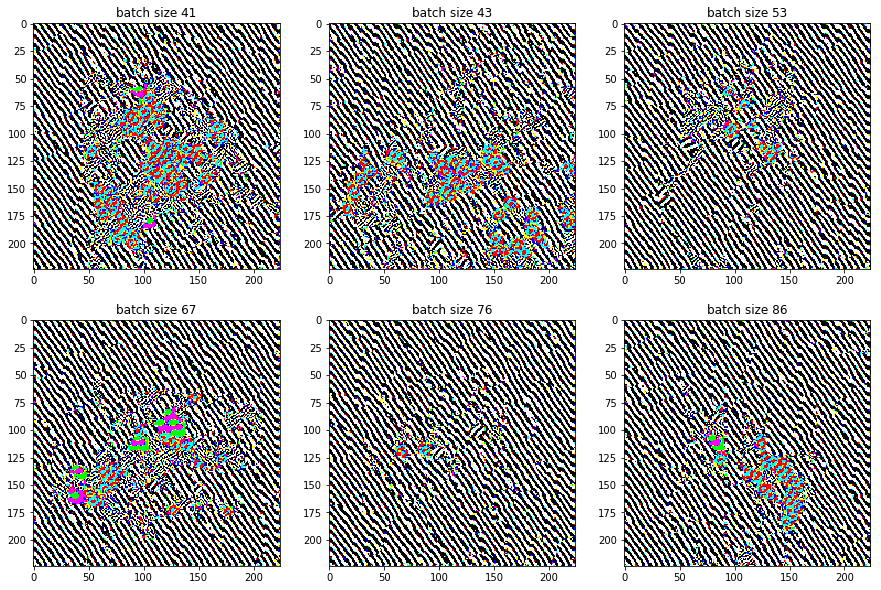

In [32]:
plt.figure(figsize=(3 * 5, 2 * 5))
random_bs_idxs = sorted(np.random.choice(len(bs_pool), replace=False, size=6))
for plot_idx, bs_idx in enumerate(random_bs_idxs, 1):
    bs = bs_pool[bs_idx]
    perturbation = perturbations[bs_idx]
    plt.subplot(2, 3, plot_idx)
    plt.title('batch size {}'.format(bs))
    plt.imshow(process_image(perturbation))
